# ODYM Example no. 6. MaTrace - Tracing material flows through different product lifecycles

Industrial ecology knows different system perspectives. Material cycles, product environmental footprints, and product life cycles are ways to explore the connections and interrelation in the industrial system and beyond. Another perspective that is relevant for the study of material cycles is the tracking of materials through different product lifecycles, answering research questions like:

+ What is the average number of product life cycles and the average lifetime of a unit of material consumed?
+ How big is the contamination of tramp elements in bulk materials over time? 
+ Where does the material consumed today ultimately end up under different waste management scenarios?

To answer these and similar questions, one needs to view material cycles as absorbing Markov Chains (Eckelman and Daigo, 2008, DOI: 10.1016/j.ecolecon.2008.05.020), where material stocks decay over time, and are partly recycled or lost to different types of waste. In the standard setting of dynamic material flow analysis, the use phase is a dynamic stock model with a lifetime distribution and the other material cycle industries are modeled as linear processes with an instantaneous response. For such a setting, the absorbing Markov Chain can be implemented as combination of a dynamic stock model and a matrix equation to solve the rest of the system, and this combination is called MaTrace model (Nakamura et al., 2014, DOI: 10.1021/es500820h) 

MaTrace has been applied to cover multiple regions (Pauliuk et al., 2017, DOI: 10.1016/j.resconrec.2016.09.029) and chemical elements at once (Nakamura et al., 2017, DOI: 10.1021/acs.est.7b01683). 

Here, we present a basic implementation of the MaTrace model in Python, using the ODYM framework for dynamic MFA. This model has some overhead regarding data formatting and model initialisation but has the advantage of that it uses tested routines and can be adapted to other cases, including multi-regional questions. The research questions for this ODYM tutorial are:
+ "How is automotive steel consumed currently (2020) dispersed into other applications over time?"
+ "What is the half-life of automotive steel in the technosphere under current waste handling conditions?"

To answer these questions the system definition is chosen as in the figure below. This figure was adapted from a recent multi-regional study applying MaTrace (Pauliuk et al., 2017, DOI: 10.1016/j.resconrec.2016.09.029) but here, only one global region is considered. The single chemical element covered is iron. The re-use flow F_2_8 as well as obsolete stock formation F_1_1a are not considered here.

<img src="Images/ODYM_MaTrace_Tutorial.png" width="1000" height="1000" alt="MaTrace system definition">

Here, we will use the multi-element and dynamic stock modelling capabilities of ODYM to address the problem of steel dispersion in the technosphere. Other related issues such as the copper contamination of steel scrap over time, which was recently addressed in a publication by Daehn et al. 2017, DOI 10.1021/acs.est.7b00997, or the fate of steel alloying elements (Nakamura et al., 2017, DOI: 10.1021/acs.est.7b01683), can be studied by extending the current model and database to cover different chemical elements.  

ODYM includes the Python class dynamic_stock_modelling for handling the inflow-driven and stock driven model of in-use stocks (http://www.teaching.industrialecology.uni-freiburg.de/  Methods section 3), and the former is applied here and combined with a matrix equation.

### ODYM model structure
The processes and system variables included are shown in the system definition. We consider the following model aspects for this model:

Time: t, 2020-2300
Age-cohort: c, 2020-2300
Element: e, Fe
Unity: 1 (mandatory for all ODYM models but not needed here)
Region: r, Global
Engineering materials: m: Construction grade steel and Automotive steel
Good: g, vehicles, machinery, construction, products and other
Waste_Scrap: w, "Heavy melt, plate, and structural steel scrap" and "Steel shred"
Scenario: S, BAU and Efficient

Here, only BAU results are calculated but the script can be modified to generate other than the default results.

### Dynamic stock model for the use phase
Stocks S and outflow O are calculated from apparent final consumption i(t), which is obtained from statistics, cf. DOI 10.1016/j.resconrec.2012.11.008 

The model equations are as follows:

First, we compute the outflow o_c(t,c) of each historic inflow/age-cohort i(c) in year t as

$$o\_c(t,c) = i(c) \cdot sf(t,c) $$

where sf is the survival function of the age cohort, which is 1-cdf (https://en.wikipedia.org/wiki/Survival_function).

The total outflow o(t) in a given year is then

$$ o(t) = \sum_{c\leq t} o\_c(t,c)$$

The mass balance leads to the stock change $dS$:

$$ dS(t) = i(t) - o(t)$$

And the stock finally is computed as

$$ S(t) = \sum_{t'\leq t} ds(t') $$ 

For the system definition above, we have $i=F_{8\_1}$, $o = F_{1\_2}$, and $S = S_{1}$.

### Solving the recycling loop
A special feature of MaTrace is that its model setup is simple enough that the recycling loop can be solved using a matrix equation despite of the several dimensions present. The crucial assumption for this simplification to work is that for any steel consumption in a given year, there is no outflow in that year, only in the years thereafter. In other words, for the first year of the product lifetime (year 0 in Python counting), there is no decay of stock, and the survival function is 1: SF(age=0) =1. That assumption is unproblematic for long-lived products such as buildings or machinery but does not hold for short-lived applications of steel such as packaging. If the share of packaging and other short-lived application in the overall model flows is significant, the model needs to be changed. Instead of solving the model differently, one can just switch the time interval from 1 year to 1 month or 1 week and rescale the flows accordingly.

First, we list the defining equations for the parameters, $\Gamma(gmw)$ (ODYM_Tutorial6_EoLRecoveryRate), $\Lambda(gmw)$ (ODYM_Tutorial6_FabricationYieldLoss), $\Theta(wm)$ (ODYM_Tutorial6_RemeltingYield) and $D(mg)$ (ODYM_Tutorial6_SectorSplit).

$$ F_{3\_4}(twe)=\sum_{cgm} \Gamma (gmw) \cdot F_{2\_3}(tcgme) $$

$$ F_{5\_6}(tme)=\sum_{w} \Theta (wm) \cdot F_{4\_5}(twe) $$

$$ F_{6\_7}(tgme)= D (mg) \cdot F_{5\_6}(tme) $$

$$ F_{7\_4}(twe)=\sum_{gm} \Lambda (gmw) \cdot F_{6\_7}(tgme) $$

Solving these equations takes a little effort because the fabrication scrap $F_{7\_4}$ is part of $F_{4\_5}$:

$$F_{4\_5} = F_{3\_4} + F_{7\_4}$$

Inserting all parameter definition equations above into the mass balance equation of process 4 leads to the following equation: (The following equation will be solved year-by-year, so that the index t is omitted.)

$$ F_{7\_4}(We) = \sum_{gmw} \Lambda (gmW) \cdot D (mg) \cdot \Theta (wm) \cdot ( F_{3\_4}(we) + F_{7\_4}(we)) $$

This equation can be solved for $F_{7\_4}$, where $I$ is the unit matrix, and W,w,m,g,e are indices:

$$ \sum_{w} I(Ww) \cdot F_{7\_4}(we) = \sum_{gmw} \Lambda (gmW) \cdot D (mg) \cdot \Theta (wm) \cdot ( F_{3\_4}(we) + F_{7\_4}(we)) $$

$$ F_{7\_4}(we) = (I-\sum_{gm}\Lambda \cdot D \cdot \Theta)^{-1}(Ww)\cdot (\sum_{gm}\Lambda \cdot D \cdot \Theta)(Ww')\cdot  F_{3\_4}(w'e)$$


From the equation above, the other variables can now be determined step by step, using the parameter definition equations.

With these explanations, we can start with the procedure:

## 1) Load ODYM


In [22]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import openpyxl
import pylab
from copy import deepcopy
import logging as log
from tqdm import tqdm

# For Ipython Notebook only
%matplotlib inline

# add ODYM module directory to system path, relative
MainPath = os.path.join('..', 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(),'..', 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join('..', 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join(os.getcwd(),'..', 'docs', 'files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename  = 'LogFile_ET6.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)


## 2) Load system classification, index table, and data 
With the model imported, we cannow set up the system definition. The 'classical' elements of the system definition in MFA include: The processes, flows, and stocks, the material, the region, and the time frame studied. Next to these elements, ODYM features/requires the following elements to be specified:
+ The list of chemical elements considered (Fe in this case)
+ The classification(s) of the system variables (stocks and flows): Which materials, products, regions, or waste groups are considered? 
+ An index letter to quickly/directly access a model aspect.
+ A dictionary of model parameters.

For all these items ODYM has a specific structure, which are coded in the model config file ODYM_Config_Tutorial6.xlsx and read using a set of customized functions.

In [23]:
#Read main script parameters
#Load project-specific config file
ProjectSpecs_ConFile = 'ODYM_Config_Tutorial6.xlsx'
Model_Configfile     = openpyxl.load_workbook(os.path.join(DataPath, ProjectSpecs_ConFile), data_only=True)
ScriptConfig         = {'Model Setting': Model_Configfile['Config'].cell(4,4).value} # Dictionary with config parameters
Model_Configsheet    = Model_Configfile['Setting_' + ScriptConfig['Model Setting']]

Name_Scenario        = Model_Configsheet.cell(4,4).value
print(Name_Scenario)

#Read control and selection parameters into dictionary
ScriptConfig         = msf.ParseModelControl(Model_Configsheet,ScriptConfig)

Mylog.info('Read and parse config table, including the model index table, from model config sheet.')
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,PL_SubFolder,PL_ProxyCode,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog)    

class_filename       = 'ODYM_Classifications_Master_Tutorial6_MaTrace.xlsx'
Classfile            = openpyxl.load_workbook(os.path.join(DataPath,class_filename), data_only=True)
Classsheet           = Classfile['MAIN_Table']
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)


INFO (1892936247.py <<module>>): Read and parse config table, including the model index table, from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.


ODYM_Tutorial6_MaTrace


With the code below, the model classifications are created from the info read with msf.ParseClassificationFile_Main.
The index table is created with the info read with msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog) .

In [24]:
Mylog.info('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.error('Item select error for aspect ' + IT_Aspects[m] + ' were found in datafile.')
        break

# Define model index table and parameter dictionary
Mylog.info('### 2.2 - Define model index table and parameter dictionary')
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start + 1

Mylog.info('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]

INFO (3620152477.py <<module>>): Define model classifications and select items for model classifications according to information provided by config file.
INFO (3620152477.py <<module>>): ### 2.2 - Define model index table and parameter dictionary
INFO (3620152477.py <<module>>): Define index table dataframe.


That dictionary of classifications enters the index table defined for the system. The index table lists all aspects needed and assigns a classification and index letter to each aspect.

In [25]:
IndexTable

,Description,Dimension,Classification,IndexLetter,IndexSize
Aspect,,,,,
Time,Model time,Time,<ODYM_Classes.Classification object at 0x00000...,t,282
Age-cohort,"Age-cohorts, vintages",Time,<ODYM_Classes.Classification object at 0x00000...,c,282
Element,chemical elements,Element,<ODYM_Classes.Classification object at 0x00000...,e,1
Unity,"trivial classification, 1 entry only",Unity,<ODYM_Classes.Classification object at 0x00000...,1,1
Region,Regions used,Region,<ODYM_Classes.Classification object at 0x00000...,r,11
Engineering materials,Engineering materials considered,Material,<ODYM_Classes.Classification object at 0x00000...,m,2
Good,Goods and products considered,Material,<ODYM_Classes.Classification object at 0x00000...,g,4
Waste_Scrap,waste and scrap types considered,Material,<ODYM_Classes.Classification object at 0x00000...,w,2
Scenario,Scenarios considered,Scenario,<ODYM_Classes.Classification object at 0x00000...,S,2


In [26]:
# Define dimension sizes
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
Ne = len(IndexTable.Classification[IndexTable.index.get_loc('Element')].Items)
Nc = len(IndexTable.Classification[IndexTable.index.get_loc('Age-cohort')].Items)
Ng = len(IndexTable.Classification[IndexTable.index.get_loc('Good')].Items)
Nm = len(IndexTable.Classification[IndexTable.index.get_loc('Engineering materials')].Items)
Nw = len(IndexTable.Classification[IndexTable.index.get_loc('Waste_Scrap')].Items)

With the index table in place, the model parameters can now be read. Note that the parameter ODYM_Tutorial6_SteelConsumption contains steel consumption data for all years from 1700-2100, but here, only the 2020 scenario value for automotive steel is used to answer the research question.

In [27]:
ParameterDict = {}
mo_start = 0 # set mo for re-reading a certain parameter
for mo in range(mo_start,len(PL_Names)):
    #ParPath = os.path.join(os.path.abspath(os.path.join(ProjectSpecs_Path_Main, '.')), 'ODYM_RECC_Database', PL_Version[mo])
    ParPath = os.path.join(DataPath, PL_Names[mo] + '_' + PL_Version[mo])
    Mylog.info('Reading parameter ' + PL_Names[mo])
    # Do not change order of parameters handed over to function!
    MetaData, Values = msf.ReadParameterXLSX(ParPath, PL_Names[mo], PL_IndexStructure[mo], PL_IndexMatch[mo],
                                         PL_IndexLayer[mo], MasterClassification, IndexTable,
                                         IndexTable_ClassificationNames, ScriptConfig, Mylog, False)
    ParameterDict[PL_Names[mo]] = msc.Parameter(Name=MetaData['Dataset_Name'], ID=MetaData['Dataset_ID'],
                                                UUID=MetaData['Dataset_UUID'], P_Res=None, MetaData=MetaData,
                                                Indices=PL_IndexStructure[mo], Values=Values, Uncert=None,
                                                Unit=MetaData['Dataset_Unit'])
    Mylog.info('Current parameter file UUID: ' + MetaData['Dataset_UUID'])
    Mylog.info('_')
Mylog.info('Reading of parameters finished.')

INFO (3100285617.py <<module>>): Reading parameter ODYM_Tutorial6_Lifetime
INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 4 values was read from file for parameter ODYM_Tutorial6_Lifetime.
INFO (ODYM_Functions.py <ReadParameterXLSX>): 4.0 of 4 values for parameter ODYM_Tutorial6_Lifetime were assigned.
INFO (3100285617.py <<module>>): Current parameter file UUID: 1ad185e8-af42-4ee1-8cc5-2215081de35c
INFO (3100285617.py <<module>>): _
INFO (3100285617.py <<module>>): Reading parameter ODYM_Tutorial6_SteelConsumption


LIST
TABLE


INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 3208 values was read from file for parameter ODYM_Tutorial6_SteelConsumption.
INFO (ODYM_Functions.py <ReadParameterXLSX>): 648.0 of 4512 values for parameter ODYM_Tutorial6_SteelConsumption were assigned.
INFO (3100285617.py <<module>>): Current parameter file UUID: 6738f872-8ec9-4ba5-986b-6da947f03289
INFO (3100285617.py <<module>>): _
INFO (3100285617.py <<module>>): Reading parameter ODYM_Tutorial6_EoLRecoveryRate
INFO (ODYM_Functions.py <ReadParameterXLSX>): A total of 8 values was read from file for parameter ODYM_Tutorial6_EoLRecoveryRate.
INFO (ODYM_Functions.py <ReadParameterXLSX>): 8.0 of 32 values for parameter ODYM_Tutorial6_EoLRecoveryRate were assigned.
INFO (3100285617.py <<module>>): Current parameter file UUID: 6213e899-8367-483a-8d09-a0c0831c22e5
INFO (3100285617.py <<module>>): _
INFO (3100285617.py <<module>>): Reading parameter ODYM_Tutorial6_FabricationYieldLoss
INFO (ODYM_Functions.py <ReadParameterXLSX>): 

LIST
LIST
LIST
LIST


Print some core data elements for info:

In [28]:
ScriptConfig

{'Model Setting': 'Tutorial6',
 'Name of model setting': 'ODYM_Tutorial6_MaTrace',
 'Description': 'Scenario analysis of dispersion of steel into different applications.',
 'Name of model script used': 'ODYM_Tutorial_6_MaTrace',
 'Version of master classification': 'ODYM_Classifications_Master_Tutorial6_MaTrace',
 'Version of ODYM Classes': 'V01',
 'Version of ODYM Functions': 'V01',
 'Logging_Verbosity': 'DEBUG'}

In [29]:
PrL_Name

['Environment',
 'Use phase',
 'EoL products trade',
 'Waste mgt. industries',
 'Waste_Scrap markets',
 'Recycling_Remelting',
 'Secondary metal market',
 'Manufacturing',
 'Product markets']

We can now define our MFA system: 

## 3) Define MFA system
This system has a name, a geographical scope, a system-wide unit, a time frame, an index table with all aspects defined, and a list of chemical elements considered.


In [30]:
MaTrace_System = msc.MFAsystem(Name = 'MaTrace_Steel_Global', 
                      Geogr_Scope = 'World', 
                      Unit = 'Mt', 
                      ProcessList = [], 
                      FlowDict = {}, 
                      StockDict = {},
                      ParameterDict = ParameterDict, 
                      Time_Start = Model_Time_Start, 
                      Time_End = Model_Time_End, 
                      IndexTable = IndexTable, 
                      Elements = IndexTable.loc['Element'].Classification.Items) # Initialize MFA system

# Add processes to system
for m in range(0, len(PrL_Number)):
    MaTrace_System.ProcessList.append(msc.Process(Name = PrL_Name[m], ID   = PrL_Number[m]))

In [31]:
# Define the flows of the system, and initialise their values:
MaTrace_System.FlowDict['F_0_8'] = msc.Flow(Name = 'exogenous final consumption of steel', P_Start = 0, P_End = 8,
                                            Indices = 't,g,m,e', Values=None)
MaTrace_System.FlowDict['F_8_1'] = msc.Flow(Name = 'final consumption', P_Start = 8, P_End = 1,
                                            Indices = 't,g,m,e', Values=None)
MaTrace_System.FlowDict['F_1_2'] = msc.Flow(Name = 'EoL products flow', P_Start = 1, P_End = 2,
                                            Indices = 't,c,g,m,e', Values=None)
MaTrace_System.FlowDict['F_2_3'] = msc.Flow(Name = 'Inflow waste mgt', P_Start = 2, P_End = 3,
                                            Indices = 't,c,g,m,e', Values=None)
MaTrace_System.FlowDict['F_3_4'] = msc.Flow(Name = 'postconsumer scrap flow', P_Start = 3, P_End = 4,
                                            Indices = 't,w,e', Values=None)
MaTrace_System.FlowDict['F_3_0'] = msc.Flow(Name = 'recovery loss', P_Start = 3, P_End = 0,
                                            Indices = 't,e', Values=None)
MaTrace_System.FlowDict['F_7_4'] = msc.Flow(Name = 'fabrication scrap flow', P_Start = 7, P_End = 4,
                                            Indices = 't,w,e', Values=None)
MaTrace_System.FlowDict['F_4_5'] = msc.Flow(Name = 'scrap flow for remelting', P_Start = 4, P_End = 5,
                                            Indices = 't,w,e', Values=None)
MaTrace_System.FlowDict['F_5_6'] = msc.Flow(Name = 'secondary metal flow', P_Start = 5, P_End = 6,
                                            Indices = 't,m,e', Values=None)
MaTrace_System.FlowDict['F_5_0'] = msc.Flow(Name = 'remelting loss', P_Start = 5, P_End = 0,
                                            Indices = 't,e', Values=None)
MaTrace_System.FlowDict['F_6_7'] = msc.Flow(Name = 'secondary metal to manufacturing', P_Start = 6, P_End = 7,
                                            Indices = 't,g,m,e', Values=None)
MaTrace_System.FlowDict['F_7_8'] = msc.Flow(Name = 'manufactured goods', P_Start = 7, P_End = 8,
                                            Indices = 't,g,m,e', Values=None)

MaTrace_System.StockDict['S_1']   = msc.Stock(Name = 'steel stock', P_Res = 1, Type = 0,
                                              Indices = 't,c,g,m,e', Values=None)
MaTrace_System.StockDict['dS_1']  = msc.Stock(Name = 'steel stock change', P_Res = 1, Type = 1,
                                              Indices = 't,g,m,e', Values=None)

MaTrace_System.Initialize_FlowValues()  # Assign empty arrays to flows according to dimensions.
MaTrace_System.Initialize_StockValues() # Assign empty arrays to flows according to dimensions.

In [32]:
# Check whether flow value arrays match their indices, etc. See method documentation.
MaTrace_System.Consistency_Check() 

(True, True, True)

Above you see that all system variables (stocks and flows) have time and element as their aspects, which is a requirement, but that other aspects (good g, material m, waste w) are assigned in a flexible manner in line with the system definition.

## 4) Programming a solution of the MFA system
Now the system definition is complete, and we can program the model solution, making use of the dynamic_stock_model methods (see also https://github.com/stefanpauliuk/dynamic_stock_model) and a matrix equation.

The solution is calculated year-by-year, as for each year, the scrap and recycling flows need to be determined and then the recycling flows are re-inserted as final consumption into the use phase.

Simplification: To make an easy year-by-year calculation possible, it is assumed that the outflow from the use phase in the same year as the consumption happened is zero. In other words, the discrete lifetime distribution for scrapping at age 0 is chosen or set to zero: $$ pdf(0) = 0; SF(0) =1 $$.

In [33]:
# ScenarioSelect to assign the scenario-specific values to the system variables
ScSe = 0

In [34]:
# 1) Pre-calculate survival tables to reduce computation time
SF_Array = np.zeros((Nc,Nc,Ng)) # survival functions, by year, age-cohort, and good. 
# PDFs are stored externally because recreating them with scipy.stats is slow.
# Build pdf array from lifetime distribution: Probability of survival.
for g in tqdm(range(0, Ng), unit = ' sectors',leave = True, position = 0):
    lt = {'Type'  : 'LogNormal',
          'Mean'  : [MaTrace_System.ParameterDict['ODYM_Tutorial6_Lifetime'].Values[g]],
          'StdDev': [MaTrace_System.ParameterDict['ODYM_Tutorial6_Lifetime'].Values[g]]}
    SF_Array[:, :, g] = dsm.DynamicStockModel(t = np.arange(0, Nc, 1), lt = lt).compute_sf().copy()
    np.fill_diagonal(SF_Array[:, :, g],1) # no outflows from current year, this would break the mass balance in the calculation routine below, as the element composition of the current year is not yet known.
    # Those parts of the stock remain in use instead.
    
# 2) Define the material-element composition of products to convert from 
# product level (dynamic stock model) to the material and element level.
Par_Material_Element_Composition_Products = np.zeros((Nc,Ng,Nm,Ne))

# 3) Assign single inflow and convert to system unit: Mt.
# modelled consumption of 2020:
MaTrace_System.FlowDict['F_0_8'].Values[0,0,:,0]  = MaTrace_System.ParameterDict['ODYM_Tutorial6_SteelConsumption'].Values[ScSe,0,0,:]/1000

# Loop over all years until end of model time
for t in tqdm(range(0,Nt), unit = ' Year', leave = True, position = 0):
    
    # 4) Compute the solution of the MaTrace model to map the flow of materials from EoL products to recycled material in new goods for final consumption.
    # (in the first year 0, the flow is 0).
    # a) Postconsumer scrap
    MaTrace_System.FlowDict['F_3_4'].Values[t,:,:] = np.einsum('gmw,cgme->we', \
        MaTrace_System.ParameterDict['ODYM_Tutorial6_EoLRecoveryRate'].Values[ScSe,:,:,:],\
        MaTrace_System.FlowDict['F_2_3'].Values[t,:,:,:,:])
    # b) Solve the 'scrap loop' in accordance with the equations listed above.
    InHom  = np.einsum('gmW,mg,wm,we->We',MaTrace_System.ParameterDict['ODYM_Tutorial6_FabricationYieldLoss'].Values[ScSe,:,:,:],\
                      MaTrace_System.ParameterDict['ODYM_Tutorial6_SectorSplit'].Values[ScSe,:,:],\
                      MaTrace_System.ParameterDict['ODYM_Tutorial6_RemeltingYield'].Values[ScSe,:,:],\
                      MaTrace_System.FlowDict['F_3_4'].Values[t,:,:])
    Matrix = np.eye(Nw) - np.einsum('gmW,mg,wm->Ww',MaTrace_System.ParameterDict['ODYM_Tutorial6_FabricationYieldLoss'].Values[ScSe,:,:,:],\
                      MaTrace_System.ParameterDict['ODYM_Tutorial6_SectorSplit'].Values[ScSe,:,:],\
                      MaTrace_System.ParameterDict['ODYM_Tutorial6_RemeltingYield'].Values[ScSe,:,:])
    
    MaTrace_System.FlowDict['F_7_4'].Values[t,:,:]   = np.linalg.inv(Matrix).dot(InHom)
    # Same as:
    # MaTrace_System.FlowDict['F_7_4'].Values[t,:,:  = np.einsum('wW,We->we',np.linalg.inv(Matrix),InHom)
    # c) calculate remaining flows from model parameters:
    MaTrace_System.FlowDict['F_4_5'].Values[t,:,:]   = MaTrace_System.FlowDict['F_3_4'].Values[t,:,:] + MaTrace_System.FlowDict['F_7_4'].Values[t,:,:]
    MaTrace_System.FlowDict['F_5_6'].Values[t,:,:]   = np.einsum('wm,we->me',MaTrace_System.ParameterDict['ODYM_Tutorial6_RemeltingYield'].Values[ScSe,:,:],MaTrace_System.FlowDict['F_4_5'].Values[t,:,:])
    MaTrace_System.FlowDict['F_6_7'].Values[t,:,:,:] = np.einsum('mg,me->gme',MaTrace_System.ParameterDict['ODYM_Tutorial6_SectorSplit'].Values[ScSe,:,:],MaTrace_System.FlowDict['F_5_6'].Values[t,:,:])
    # d) finally, use the mass balance to compute the outflows:
    MaTrace_System.FlowDict['F_3_0'].Values[t,:]     = np.einsum('cgme->e',MaTrace_System.FlowDict['F_2_3'].Values[t,:,:,:,:]) -\
                      np.einsum('we->e',MaTrace_System.FlowDict['F_3_4'].Values[t,:,:])
    MaTrace_System.FlowDict['F_5_0'].Values[t,:]     = np.einsum('we->e',MaTrace_System.FlowDict['F_4_5'].Values[t,:,:]) -\
                      np.einsum('me->e',MaTrace_System.FlowDict['F_5_6'].Values[t,:,:])  
    FabYield = 1 - np.einsum('gmw->gm',MaTrace_System.ParameterDict['ODYM_Tutorial6_FabricationYieldLoss'].Values[ScSe,:,:,:])
    MaTrace_System.FlowDict['F_7_8'].Values[t,:,:,:] = np.einsum('gme,gm->gme',MaTrace_System.FlowDict['F_6_7'].Values[t,:,:,:],\
                      FabYield)        

    # 5) Add exogenous final consumption to recycled flows:
    MaTrace_System.FlowDict['F_8_1'].Values[t,:,:,:] = MaTrace_System.FlowDict['F_7_8'].Values[t,:,:,:] + MaTrace_System.FlowDict['F_0_8'].Values[t,:,:,:]

    # 6) Calculate the material-element composition of products for current age-cohort
    for g in range(0,Ng):
        if MaTrace_System.FlowDict['F_8_1'].Values[t,g,:,:].sum() != 0:
            Par_Material_Element_Composition_Products[t,g,:,:] = MaTrace_System.FlowDict['F_8_1'].Values[t,g,:,:] / MaTrace_System.FlowDict['F_8_1'].Values[t,g,:,:].sum()
        
    # 7) Define and solve dynamic stock model to calculate next year's outflow
    # Create helper DSM for computing the dynamic stock model:
    # Here, the mass of the product g is its total mass.
    # A lognormal lifetime distribution with mean = stddev is assumed.
    for g in range(0,Ng):
        DSM_MaTrace = dsm.DynamicStockModel(t = np.arange(0, Nt, 1),
                                            i = np.einsum('tme->t',MaTrace_System.FlowDict['F_8_1'].Values[:,g,:,:]),
                                           lt = {'Type': 'LogNormal', 'Mean': [MaTrace_System.ParameterDict['ODYM_Tutorial6_Lifetime'].Values[g]],
                                             'StdDev': [MaTrace_System.ParameterDict['ODYM_Tutorial6_Lifetime'].Values[g]]})
        
        # Here, the lt attribute is not used, instead, we assign the pre-calculated SF array:
        DSM_MaTrace.sf  = SF_Array[:,:,g]
    
        Stock_by_cohort = DSM_MaTrace.compute_s_c_inflow_driven()
        O_C             = DSM_MaTrace.compute_o_c_from_s_c()
        S               = DSM_MaTrace.compute_stock_total()
        DS              = DSM_MaTrace.compute_stock_change()
        DS_C            = np.zeros(Stock_by_cohort.shape)
        DS_C[0,:]       = Stock_by_cohort[0,:]
        DS_C[1::,:]     = np.diff(Stock_by_cohort,axis=0)
        
        # 8) Map flows and stocks at goods level g to materials and elements:
        MaTrace_System.FlowDict['F_1_2'].Values[:,:,g,:,:] = np.einsum('tc,cme->tcme',O_C,            Par_Material_Element_Composition_Products[:,g,:,:]).copy()
        MaTrace_System.FlowDict['F_2_3'].Values[:,:,g,:,:] = MaTrace_System.FlowDict['F_1_2'].Values[:,:,g,:,:].copy()
        MaTrace_System.StockDict[ 'S_1'].Values[:,:,g,:,:] = np.einsum('tc,cme->tcme',Stock_by_cohort,Par_Material_Element_Composition_Products[:,g,:,:]).copy()
        MaTrace_System.StockDict['dS_1'].Values[:,g,:,:]   = np.einsum('tc,cme->tme', DS_C,           Par_Material_Element_Composition_Products[:,g,:,:]).copy()
        
        # NOTE: The computation above is still quite inefficient as many redundant results are generated. 
        # If speed is an issue, e.g., for MC simulations, the code can be sped up by customizing the dynamic stock model functions to the case at hand
        # or directly programming the solution using np.einsum('...',Inflow,SurvivalTable)
        # Here, the dynamic stock model library was used because its methods are tested.
    
#
#

100%|██████████| 282/282 [00:05<00:00, 48.01 Year/s]


## 5) Mass-balance-check
One major advantage of the ODYM system structure is that mass balance checks can be performed automatically using unit-tested routines without further programming need:

In [35]:
Bal = MaTrace_System.MassBalance()
print(Bal.shape) # dimensions of balance are: time step x process x chemical element
print(np.abs(Bal).sum(axis = 0)) # reports the sum of all absolute balancing errors by process.

(282, 9, 1)
[[1.70280456e-13]
 [1.63036251e-13]
 [0.00000000e+00]
 [0.00000000e+00]
 [2.37587727e-14]
 [0.00000000e+00]
 [1.99840144e-14]
 [3.88855614e-14]
 [0.00000000e+00]]


The ODYM mass balance array reports the balance for each chemical element, each year, and each process, including the system balance (process 0).

The result shows that both the system processes and the system as a whole are balanced.

## 6) Research questions and results
We now address the research questions. First, we plot the steel stock in the different applications over time (RQ1):

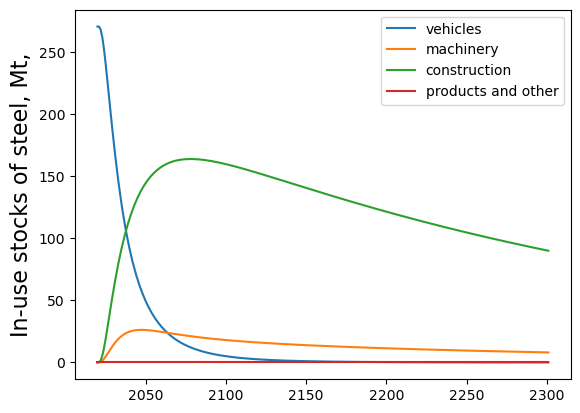

In [36]:
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
ax.plot(MaTrace_System.IndexTable['Classification']['Time'].Items, 
            np.einsum('tcgme->tg',MaTrace_System.StockDict[ 'S_1'].Values)) 
ax.set_ylabel('In-use stocks of steel, Mt,',fontsize =16)
ax.legend(MaTrace_System.IndexTable['Classification']['Good'].Items, loc='upper right',prop={'size':10})

The steel stock in vehicles remains stable for a few years and then quickly declines as the vehicles reach their typical lifetime (ca. 15 years). According to the model parameters (remelting yield), the recovered steel shred from vehicles is down-cycled (cascaded) into construction type steel, which in this dataset is used for both construction and machinery. (To have more realistic depictions of the steel cycle, one can introduce more steel categories, but that also increases the data need). Due to the longer lifetime of steel in construction, steel tends to accumulate there, including steel that was first cascaded into machinery and then into buildings. Ultimately, steel stocks slowly decline due to the recovery and remelting losses that occur every time the steel is remelted into new rebars or steel girders. In remelting alone, ca. 6% of the metal are lost to slag each time, and to reduce both these losses and the associated energy demand, steel can be re-used instead of remelted. The re-use strategy is described in detail in the 2012 book "Sustainable Materials - With Both Eyes Open" by Allwood and colleagues (http://www.withbotheyesopen.com/).

To answer RQ2, let's plot the total stock as the sum of the four curves above.

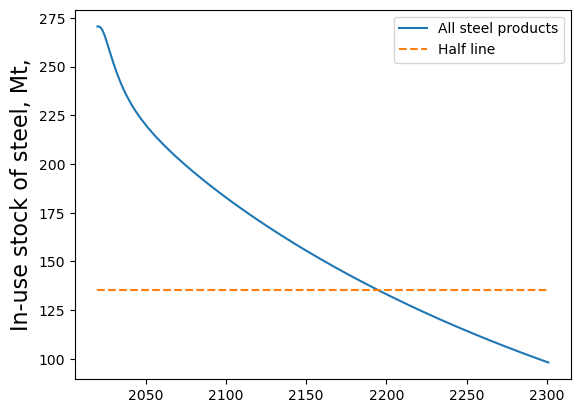

In [37]:
plt.set_loglevel("info") 

HalfLine = 0.5 * MaTrace_System.StockDict[ 'S_1'].Values[0,:,:,:,:].sum()

MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
ax.plot(MaTrace_System.IndexTable['Classification']['Time'].Items, 
            np.einsum('tcgme->t',MaTrace_System.StockDict[ 'S_1'].Values)) 
ax.plot(MaTrace_System.IndexTable['Classification']['Time'].Items, 
            HalfLine * np.ones(len(MaTrace_System.IndexTable['Classification']['Time'].Items)), linestyle = '--') 
ax.set_ylabel('In-use stock of steel, Mt,',fontsize =16)
ax.legend(['All steel products','Half line'], loc='upper right',prop={'size':10})

We see that around a bit before the year 2200, ca. 175 years after the initial consumption in 2020, only half of the steel remains in useful applications in the technosphere. The technical half-life of the steel is thus ca. 175 years.
Given that the climate impacts of current steel production will persist for much longer, one can conclude that such a metal use pattern is not sustainable.

Another question, which is not addressed here, is how tramp elements accumulate in the steel and reduce its quality, especially copper and tin. This topic is addressed by a recent publication by Daehn et al. (2017), DOI 10.1021/acs.est.7b00997.

The code here shows how a systematic MFA model can be set up to answer these types of question. This tutorial illustrates the use of the ODYM functions and data format for material tracing questions, its main emphasis is therefore on the technical aspects of the modelling. The questions posed here can be addressed with simpler models, e.g., models based in Excel. Once the approach becomes more detailed, however, e.g., when other elements, scenarios, and multiple regions are included, the hand-wired approaches will quickly reach their limits, and a systematic approach like the one presented here will prove very powerful.

## 7) Save data and results
Save entire system: 

In [38]:
# pickle.dump( {'MaTrace_System': MaTrace_System}, open( "Tutorial6_MaTrace_System.p", "wb" ) )